In [1]:
import torch
import string
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 1

### Create Palindrome Dataset

In [2]:
def generate_random_string(length):
    return ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), length))


def generate_palindrome(length):
    half_length = length // 2
    half_string = generate_random_string(half_length)
    if length % 2 == 0:
        return half_string + half_string[::-1]
    else:
        return half_string + np.random.choice(list('abcdefghijklmnopqrstuvwxyz')) + half_string[::-1]
    

def generate_dataset(num_samples, string_lengths):
    data = []
    num_samples_per_length = num_samples // len(string_lengths)
    for length in string_lengths:
        for _ in range(num_samples_per_length):
            if np.random.rand() > 0.5:
                string = generate_random_string(length)
                label = 1
            else:
                string = generate_palindrome(length)
                label = 0
            data.append([string, label])
    return data


### Create Manual Palindrome Model

In [3]:
class CustomTokenizer:
    def __init__(self):
        # Define the special tokens
        self.tokens = list(string.ascii_lowercase)
        self.token_to_id = {token: i for i, token in enumerate(self.tokens)}
        self.id_to_token = {i: token for token, i in enumerate(self.tokens)}
        self.vocab = set(self.tokens)
        self.vocab_size = len(self.vocab)
        self.max_word_length = 200
    
    def to_matrix(self, word):
        rows = len(word)
        cols = len(self.vocab)
        matrix = torch.zeros((rows, cols), dtype=torch.float32)
        for i, char in enumerate(word):
            matrix[i, self.token_to_id[char]] = 1.0
        return matrix
    
class PalindromeNetwork(nn.Module):
    def __init__(self):
        super(PalindromeNetwork, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = torch.flip(torch.eye(self.tokenizer.max_word_length), [0])
        

    def forward(self, x):
        word_len = len(x)
        P = self.tokenizer.to_matrix(x)
        d = torch.norm(P - self.IPrime[-1*word_len:, :word_len].matmul(P), p="fro")
        return d
    
net = PalindromeNetwork()

print("Output for 'aba': ", net("aba").item())
print("Output for 'abb': ", net("abb").item())
print("Output for 'cba': ", net("cba").item())
print("Output for 'racecar': ", net("racecar").item())
print("Output for 'saippuakivikauppias': ", net("saippuakivikauppias").item())


Output for 'aba':  0.0
Output for 'abb':  2.0
Output for 'cba':  2.0
Output for 'racecar':  0.0
Output for 'saippuakivikauppias':  0.0


### Expirement 1: Learning the Reverse Identity Matrix

In [4]:
class CustomTokenizer:
    def __init__(self):
        # Define the special tokens
        self.tokens = list(string.ascii_lowercase)
        self.token_to_id = {token: i for i, token in enumerate(self.tokens)}
        self.id_to_token = {i: token for token, i in enumerate(self.tokens)}
        self.vocab = set(self.tokens)
        self.vocab_size = len(self.vocab)
        self.max_word_length = 7
    
    def to_matrix(self, word):
        rows = len(word)
        cols = len(self.vocab)
        matrix = torch.zeros((rows, cols), dtype=torch.float32)
        for i, char in enumerate(word):
            matrix[i, self.token_to_id[char]] = 1.0
        return matrix
    
class PalindromeNetwork(nn.Module):
    def __init__(self):
        super(PalindromeNetwork, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = nn.Parameter(torch.zeros(self.tokenizer.max_word_length,self.tokenizer.max_word_length))

    def forward(self, P):
        word_len = P.shape[0]
        d = torch.norm(P - self.IPrime[-1*word_len:, :word_len].matmul(P), p="fro")
        d = nn.functional.tanh(d)
        return d

dataset = generate_dataset(10000, [3,4,5])
tokenizer = CustomTokenizer()
X = []
for row in dataset:
    X.append([tokenizer.to_matrix(row[0]), row[1]])


# Training loop
model = PalindromeNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 7
for epoch in range(num_epochs):
    total_loss = 0
    for data in X:
        inputs, label = data
        label = torch.tensor([label], dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(X):.4f}')


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/7], Loss: 0.0275
Epoch [2/7], Loss: 0.0088
Epoch [3/7], Loss: 0.0087
Epoch [4/7], Loss: 0.0087
Epoch [5/7], Loss: 0.0087
Epoch [6/7], Loss: 0.0086
Epoch [7/7], Loss: 0.0086


[[ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.46 -0.   -0.    0.    0.54  0.    0.  ]
 [ 0.15  0.08  0.    0.92 -0.15  0.    0.  ]
 [-0.03 -0.03  1.    0.03  0.03  0.    0.  ]
 [ 0.02  1.02 -0.   -0.02 -0.02  0.    0.  ]
 [ 1.07  0.06  0.   -0.06 -0.07  0.    0.  ]]


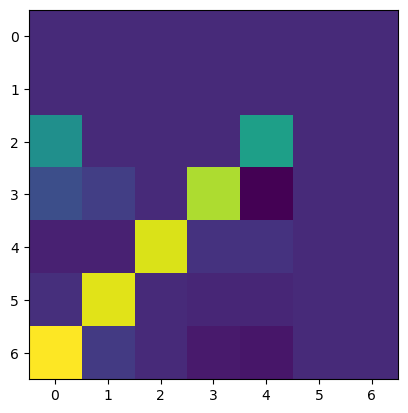

In [5]:
print(model.IPrime.detach().numpy().round(2))
plt.imshow(model.IPrime.detach().numpy())

In [6]:
print(model(tokenizer.to_matrix("abbba")))
print(model(tokenizer.to_matrix("abbbba")))

tensor(0.0002, grad_fn=<TanhBackward0>)
tensor(0.8383, grad_fn=<TanhBackward0>)


### Expirement 2: Replacing the Subtraction & Norm


In [7]:
class PalindromeNetwork2(nn.Module):
    def __init__(self):
        super(PalindromeNetwork2, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = nn.Parameter(torch.zeros(self.tokenizer.max_word_length,self.tokenizer.max_word_length))
        self.fc2 = nn.Linear(26,26)
        self.fc3 = nn.Linear(26,1)


    def forward(self, P):
        word_len = P.shape[0]
        d = self.IPrime[-1*word_len:, :word_len].matmul(P)
        out = P + d
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        out = torch.sum(out, dim=0)
        out = nn.functional.sigmoid(out)
        return out

dataset = generate_dataset(10000, [3,4,5])
tokenizer = CustomTokenizer()
X = []
for row in dataset:
    X.append([tokenizer.to_matrix(row[0]), row[1]])


# Split the dataset into training and test sets
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Training loop
model = PalindromeNetwork2()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for data in train_data:
        inputs, label = data
        label = torch.tensor([label], dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_data:
            inputs, label = data
            label = torch.tensor([label], dtype=torch.float32)
            
            outputs = model(inputs)
            loss = criterion(outputs, label)
            total_test_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss/len(train_data):.4f}, Test Loss: {total_test_loss/len(test_data):.4f}')

print(model.IPrime.detach().numpy().round(2))


Epoch [1/40], Train Loss: 0.5348, Test Loss: 0.1558
Epoch [2/40], Train Loss: 0.1009, Test Loss: 0.0710
Epoch [3/40], Train Loss: 0.0755, Test Loss: 0.0615
Epoch [4/40], Train Loss: 0.0692, Test Loss: 0.0571
Epoch [5/40], Train Loss: 0.0651, Test Loss: 0.0555
Epoch [6/40], Train Loss: 0.0621, Test Loss: 0.0546
Epoch [7/40], Train Loss: 0.0598, Test Loss: 0.0547
Epoch [8/40], Train Loss: 0.0580, Test Loss: 0.0550
Epoch [9/40], Train Loss: 0.0568, Test Loss: 0.0552
Epoch [10/40], Train Loss: 0.0555, Test Loss: 0.0548
Epoch [11/40], Train Loss: 0.0545, Test Loss: 0.0553
Epoch [12/40], Train Loss: 0.0537, Test Loss: 0.0552
Epoch [13/40], Train Loss: 0.0528, Test Loss: 0.0552
Epoch [14/40], Train Loss: 0.0520, Test Loss: 0.0554
Epoch [15/40], Train Loss: 0.0513, Test Loss: 0.0552
Epoch [16/40], Train Loss: 0.0507, Test Loss: 0.0550
Epoch [17/40], Train Loss: 0.0502, Test Loss: 0.0547
Epoch [18/40], Train Loss: 0.0497, Test Loss: 0.0541
Epoch [19/40], Train Loss: 0.0493, Test Loss: 0.0539
Ep

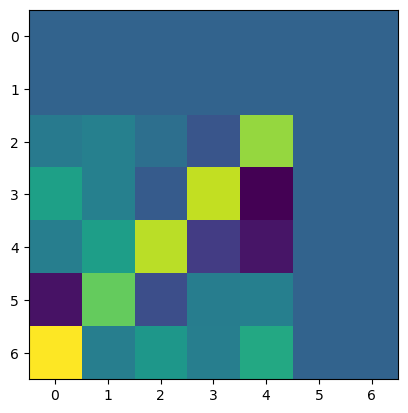

In [8]:
plt.imshow(model.IPrime.detach().numpy())

### Example 3: Adding Regularization

In [9]:
class PalindromeNetwork3(nn.Module):
    def __init__(self):
        super(PalindromeNetwork3, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = nn.Parameter(torch.zeros(self.tokenizer.max_word_length,self.tokenizer.max_word_length))
        self.fc2 = nn.Linear(26,26)
        self.fc3 = nn.Linear(26,1)


    def forward(self, P):
        word_len = P.shape[0]
        d = self.IPrime[-1*word_len:, :word_len].matmul(P)
        out = P + d
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        out = torch.sum(out, dim=0)
        out = nn.functional.sigmoid(out)
        return out
    
dataset = generate_dataset(10000, [3,4,5])
tokenizer = CustomTokenizer()
X = []
for row in dataset:
    X.append([tokenizer.to_matrix(row[0]), row[1]])


# Split the dataset into training and test sets
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Training loop
model = PalindromeNetwork3()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for data in train_data:
        inputs, label = data
        label = torch.tensor([label], dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, label)

        # Add regularization to encourage outputs closer to 0 or 1
        regularization = 0.01 * torch.sum((model.IPrime * (1 - model.IPrime))**2)
        loss += regularization
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_data:
            inputs, label = data
            label = torch.tensor([label], dtype=torch.float32)
            
            outputs = model(inputs)
            loss = criterion(outputs, label)
            total_test_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss/len(train_data):.4f}, Test Loss: {total_test_loss/len(test_data):.4f}')

print(model.IPrime.detach().numpy().round(2))


Epoch [1/40], Train Loss: 0.7048, Test Loss: 0.6952
Epoch [2/40], Train Loss: 0.4604, Test Loss: 0.1395
Epoch [3/40], Train Loss: 0.0972, Test Loss: 0.0831
Epoch [4/40], Train Loss: 0.0684, Test Loss: 0.0703
Epoch [5/40], Train Loss: 0.0587, Test Loss: 0.0646
Epoch [6/40], Train Loss: 0.0537, Test Loss: 0.0617
Epoch [7/40], Train Loss: 0.0508, Test Loss: 0.0601
Epoch [8/40], Train Loss: 0.0489, Test Loss: 0.0592
Epoch [9/40], Train Loss: 0.0475, Test Loss: 0.0585
Epoch [10/40], Train Loss: 0.0466, Test Loss: 0.0581
Epoch [11/40], Train Loss: 0.0458, Test Loss: 0.0580
Epoch [12/40], Train Loss: 0.0453, Test Loss: 0.0579
Epoch [13/40], Train Loss: 0.0449, Test Loss: 0.0579
Epoch [14/40], Train Loss: 0.0445, Test Loss: 0.0579
Epoch [15/40], Train Loss: 0.0442, Test Loss: 0.0580
Epoch [16/40], Train Loss: 0.0440, Test Loss: 0.0581
Epoch [17/40], Train Loss: 0.0438, Test Loss: 0.0581
Epoch [18/40], Train Loss: 0.0435, Test Loss: 0.0582
Epoch [19/40], Train Loss: 0.0434, Test Loss: 0.0582
Ep

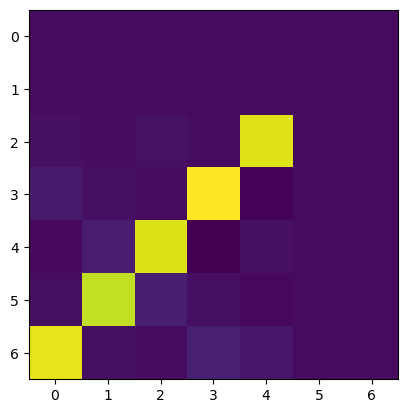

In [10]:
plt.imshow(model.IPrime.detach().numpy())

### Modifying the Network with Program Synthesis

In [15]:
class PalindromeNetwork4(nn.Module):
    def __init__(self):
        super(PalindromeNetwork4, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = nn.Parameter(torch.zeros(self.tokenizer.max_word_length,self.tokenizer.max_word_length))
        self.fc2 = nn.Linear(26,26)
        self.fc3 = nn.Linear(26,1)


    def forward(self, P):
        word_len = P.shape[0]
        d = self.IPrime[-1*word_len:, :word_len].matmul(P)
        out = P + d
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        out = torch.sum(out, dim=0)
        out = nn.functional.sigmoid(out)
        return out
    
dataset = generate_dataset(10000, [3,4,5])
tokenizer = CustomTokenizer()
X = []
for row in dataset:
    X.append([tokenizer.to_matrix(row[0]), row[1]])


# Split the dataset into training and test sets
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Training loop
model = PalindromeNetwork4()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for data in train_data:
        inputs, label = data
        label = torch.tensor([label], dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, label)

        # Add regularization to encourage outputs closer to 0 or 1
        regularization = 0.01 * torch.sum((model.IPrime * (1 - model.IPrime))**2)
        loss += regularization
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_data:
            inputs, label = data
            label = torch.tensor([label], dtype=torch.float32)
            
            outputs = model(inputs)
            loss = criterion(outputs, label)
            total_test_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss/len(train_data):.4f}, Test Loss: {total_test_loss/len(test_data):.4f}')


Epoch [1/40], Train Loss: 0.5691, Test Loss: 0.1865
Epoch [2/40], Train Loss: 0.1114, Test Loss: 0.0846
Epoch [3/40], Train Loss: 0.0690, Test Loss: 0.0673
Epoch [4/40], Train Loss: 0.0571, Test Loss: 0.0599
Epoch [5/40], Train Loss: 0.0516, Test Loss: 0.0564
Epoch [6/40], Train Loss: 0.0484, Test Loss: 0.0548
Epoch [7/40], Train Loss: 0.0465, Test Loss: 0.0540
Epoch [8/40], Train Loss: 0.0451, Test Loss: 0.0538
Epoch [9/40], Train Loss: 0.0442, Test Loss: 0.0537
Epoch [10/40], Train Loss: 0.0435, Test Loss: 0.0537
Epoch [11/40], Train Loss: 0.0429, Test Loss: 0.0540
Epoch [12/40], Train Loss: 0.0425, Test Loss: 0.0542
Epoch [13/40], Train Loss: 0.0421, Test Loss: 0.0546
Epoch [14/40], Train Loss: 0.0418, Test Loss: 0.0547
Epoch [15/40], Train Loss: 0.0416, Test Loss: 0.0550
Epoch [16/40], Train Loss: 0.0413, Test Loss: 0.0551
Epoch [17/40], Train Loss: 0.0411, Test Loss: 0.0554
Epoch [18/40], Train Loss: 0.0410, Test Loss: 0.0557
Epoch [19/40], Train Loss: 0.0408, Test Loss: 0.0559
Ep

In [27]:
def synthesize_rule(target_matrix, in_distribution_indices):
    def equality_condition(a, b):
        return a == b
    def reverse_equality_condition(a, b):
        return target_matrix.shape[0] - a == b
    def inequality_condition(a, b):
        return a != b
    def greater_than_condition(a, b):
        return a > b
    def less_than_condition(a, b):
        return a < b
    # ... continue with a comprehensive DSL of conditions

    possible_conditions = [
        equality_condition,
        reverse_equality_condition,
        inequality_condition,
        greater_than_condition,
        less_than_condition,
        # ... add more conditions as needed
    ]

    # Perform a very basic search for a condition that holds for all elements
    # This is a placeholder for a more sophisticated search algorithm
    for condition in possible_conditions:
        condition_holds = True
        for i in range(target_matrix.shape[0]):
            for j in range(target_matrix.shape[1]):

                # Skip elements not in the in-distribution indices - they will not contain
                # any information about the rule
                if i not in in_distribution_indices or j not in in_distribution_indices:
                    continue

                # Check if the condition holds for all elements that are in-distribution
                if target_matrix[i][j] == 1 and not condition(i, j):
                    condition_holds = False
                    break
                if target_matrix[i][j] == 0 and condition(i, j):
                    condition_holds = False
                    break
        if condition_holds:
            print(f"Found condition: {condition.__name__}")
            return condition
    return None


# Get I'
discretized_matrix = model.IPrime.detach().numpy()

# Round the values to 0 or 1
discretized_matrix[discretized_matrix < 0.5] = 0
discretized_matrix[discretized_matrix >= 0.5] = 1

condition_rule = synthesize_rule(model.IPrime.detach().numpy(), [3,4,5])
with torch.no_grad():
    for i in range(model.IPrime.shape[0]):
        for j in range(model.IPrime.shape[1]):
            if condition_rule(i, j):
                model.IPrime[i][j] = 1
            else:
                model.IPrime[i][j] = 0


print(model(tokenizer.to_matrix("abbba")))
print(model(tokenizer.to_matrix("abbbba")))

Found condition: reverse_equality_condition
tensor([0.9978], grad_fn=<SigmoidBackward0>)
tensor([0.9853], grad_fn=<SigmoidBackward0>)
